In [1]:
import numpy as np
#from scipy.interpolate import RectBivariateSpline
import scipy.interpolate as interpolate
import datetime as dt
import os
from copy import deepcopy as cp
import netCDF4 as nc
import sys
from dask import delayed
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
#import warnings
# Import writer class from csv module
from csv import writer
import xarray as xr
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.patches import Polygon
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
#SCENARIO_COMBNATION = ['frst-ctl','crop-ctl']
SCENARIO_COMBNATION = ['crop-ctl','frst-ctl','irri-crop']
region_list= ['CSAM', 'CAF', 'CE']
scenario_title=['CROP-CTL','FRST-CTL','IRR-CROP']

box_coords = [
    [(244,244,267,267,244), (29,54,54,29,29)],
    [(35,35,92,92,35), (43,60,60,43,43)],
    [(284,284,305,305,284), (-11,5,5,-11,-11)],
    [(11,11,32,32,11), (-9,8,8,-9,-9)],
    [(305,305,321,321,305), (-24,-3,-3,-24,-24)],
    [(14,14,35,35,14), (-23,-9,-9,-23,-23)],
    [(94,94,120,120,94), (24,41,41,24,24)]
]
region_names = [
    "WNA",  # Western North America
    "EES",  # East Europe Siberia
    "WAB",  # Western Amazon Basin
    "CCB",  # Central Congo Basin
    "EAB",  # Eastern Amazon Basin
    "SCP",  # Southern Congo Periphery
    "EC"    # Eastern China
]
def create_10level_cmap():
    # 从 "RdBu_r" 采样 10 个区分度高的颜色（蓝5 + 红5）
    cmap = cm.get_cmap('BrBG')
    colors = [cmap(i)[:3] for i in [0, 28, 56, 85, 113, 143, 170, 198, 226, 255]]
    return LinearSegmentedColormap.from_list('10level_cmap', colors, N=256)

i=0, j=0, index=0
i=1, j=0, index=1
i=2, j=0, index=2
i=0, j=1, index=3
i=1, j=1, index=4
i=2, j=1, index=5
i=0, j=2, index=6
i=1, j=2, index=7
i=2, j=2, index=8


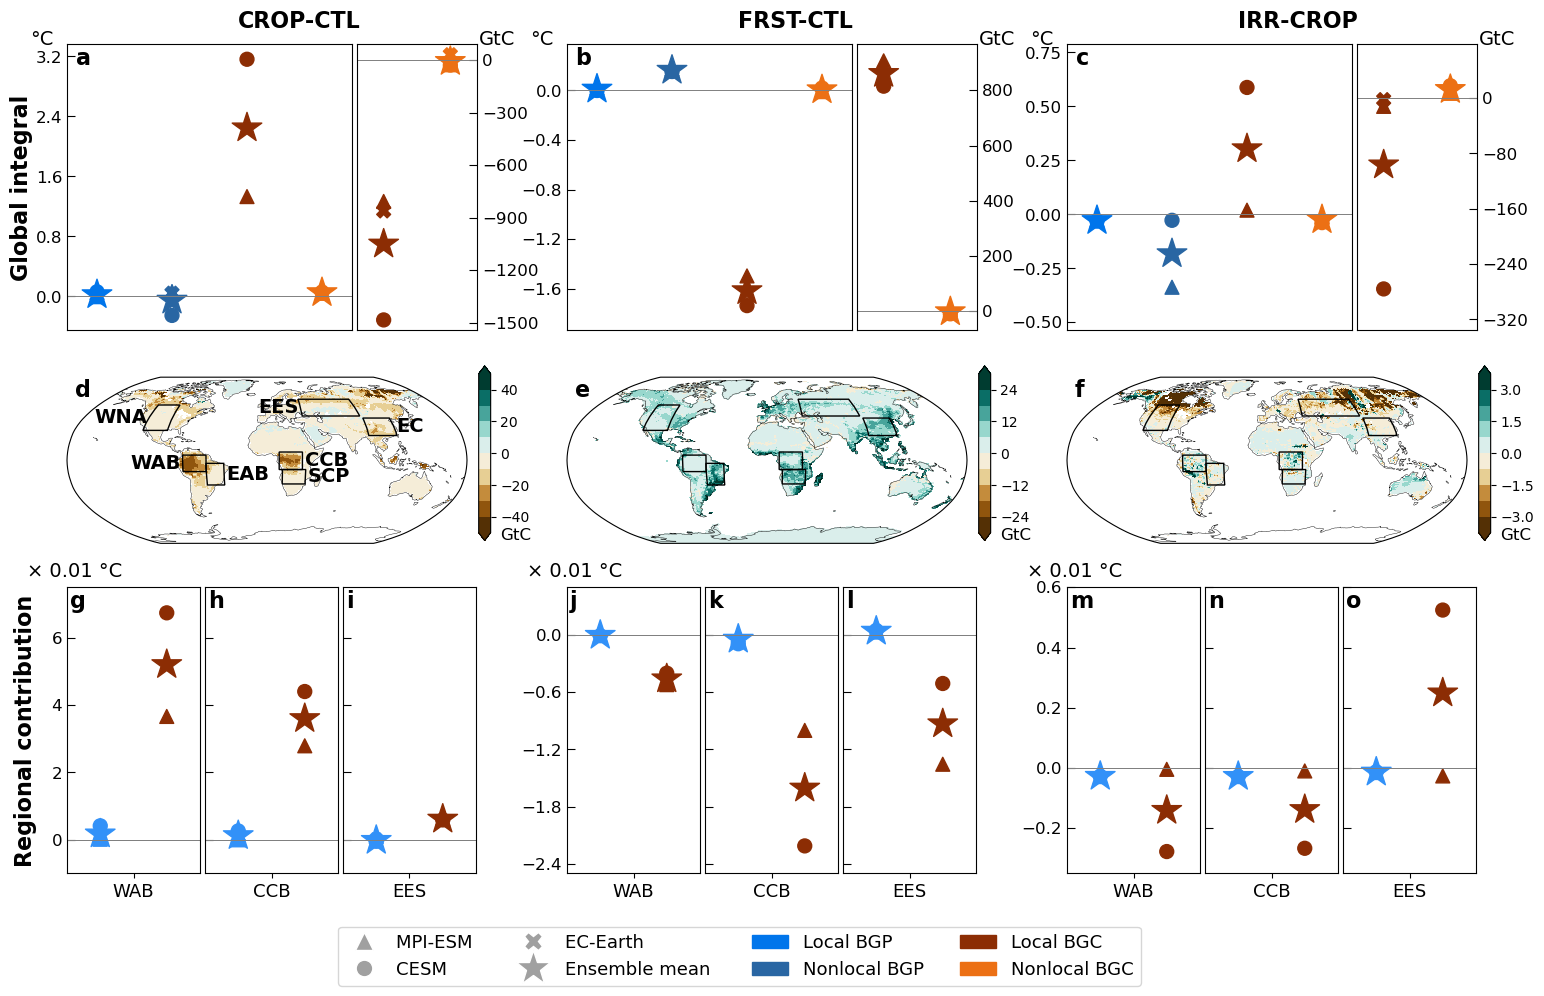

<Figure size 1000x600 with 0 Axes>

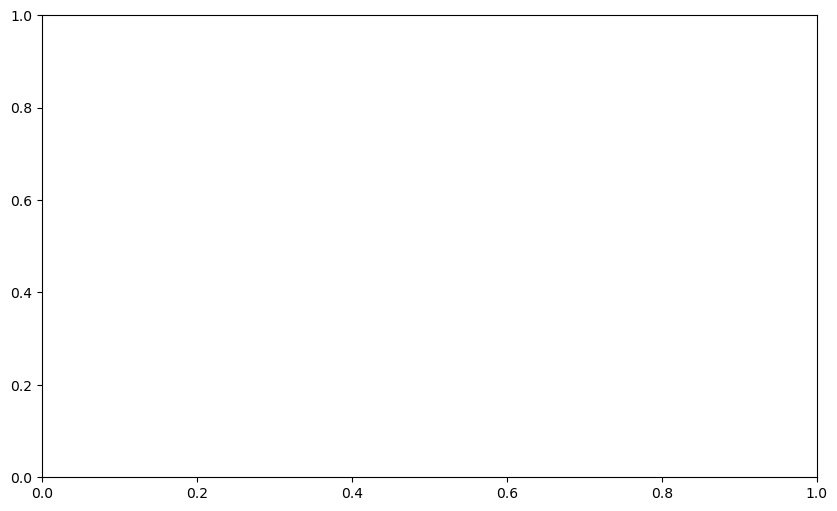

<Figure size 1000x600 with 0 Axes>

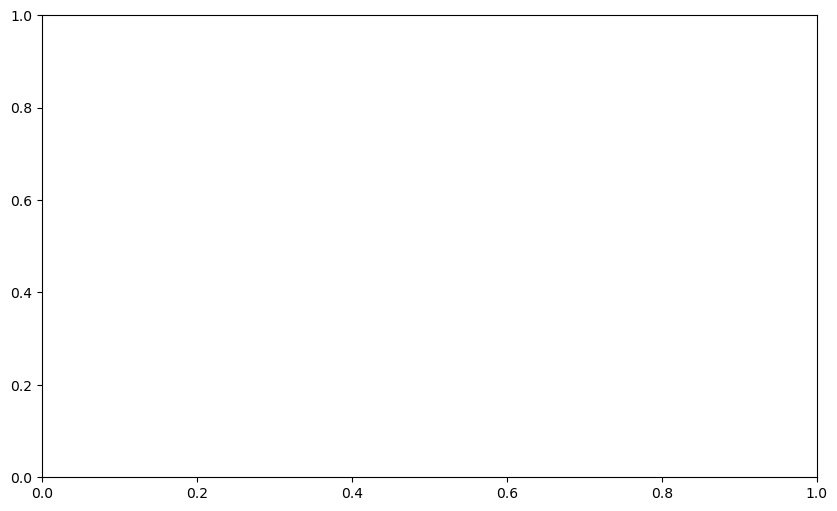

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [11]:
fig = plt.figure(constrained_layout= False)
#fig.subplots_adjust(wspace= 10, hspace= 0)
subfigs = fig.subfigures(3, 3, height_ratios=[1,0.6,1], wspace= 0, hspace= 0)
#subfigs.layout(None)
#subfigs.subplots_adjust(wspace=0, hspace=0)
#fig.tight_layout(pad= 0)
fig.set_size_inches(15,8)
for j, SCENARIO in enumerate(SCENARIO_COMBNATION):
    '''
    if SCENARIO == 'irri-crop':
        tas_global = xr.open_dataset(
            f"/work/bm1147/b380949/web-monitoring/secP/ensemble/cLand_ensemble/tas_irr-crop_3models-ensemble.nc"
        )
    else:
    '''
    cLand_global = xr.open_dataset(
            f"/work/bm1147/b380949/web-monitoring/secP/ensemble/cLand_ensemble/ensemble_selmodel/cLand_{SCENARIO}_last30mean_models-ensemble_exclecearth_4frst_4irrnonlocal-total.nc")
    cLand_data = cLand_global['cLand_local'].isel(time=0)
    labels = list("def")  
    label_idx = j
        
    ax = subfigs[1, j].subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()})
    ax.text(0.02, 0.99, labels[j], transform=ax.transAxes,
                    fontsize=16, fontweight='bold', va='top', ha='left')
    ax.set_position([0.005, 0.13, 0.8, 0.9])
    #bounds = [-2, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6,2]
    # 设置每列单独 colorbar 的边界值（可改为动态设定）
    if SCENARIO == 'frst-ctl':
        bounds = [-30, -24, -18, -12, -6, 0, 6, 12, 18, 24, 30]
    elif SCENARIO == 'irri-crop':
        bounds = [-3.75, -3, -2.25, -1.5, -0.75, 0, 0.75, 1.5, 2.25, 3, 3.75]
    else:
        bounds = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40,50]
        
    norm = BoundaryNorm(bounds, 256)
    im = ax.pcolormesh(cLand_data.lon, cLand_data.lat, cLand_data, 
                        transform=ccrs.PlateCarree(),
                        cmap=create_10level_cmap(), norm=norm)
    ax.set_xticks([])  # 去掉刻度防止重叠
    ax.set_yticks([])
    ax.set_aspect('auto')
        
    for idx, box in enumerate(box_coords):
                lon, lat = box
                poly = Polygon(list(zip(lon, lat)), closed=True,
                               transform=ccrs.PlateCarree(),
                               edgecolor='black', facecolor='none',
                               linewidth=1)
                ax.add_patch(poly)

                # 计算标注位置（左侧或右侧靠边）
                if idx <= 2:
        # 前3个区域，在左侧标注
                    text_lon = min(lon[:-1]) - 2
                    ha = 'right'
                else:
        # 后4个区域，在右侧标注
                    text_lon = max(lon[:-1]) + 2
                    ha = 'left'
            
                text_lat = sum(lat[:-1]) / len(lat[:-1])  # 使用纬度中值对齐

                if j==0:
                    ax.text(text_lon, text_lat, region_names[idx],
                        transform=ccrs.PlateCarree(),
                        fontsize=14, fontweight='bold',
                        color='black',
                        ha=ha, va='center')
                
    x_position=[3.1, 1.85, 0.6]
    cax = inset_axes(ax,          
                     width="9%",     # 相对于 ax 的宽度
                     height="95%",   # 相对于 ax 的高度
                     loc='lower left',
                     bbox_to_anchor=(x_position[j], -1.3, 1, 4.8),
                     bbox_transform=ax.transAxes,
                     borderpad=0)

    #cax = fig.add_axes([colorbar_x_positions[j], 0.4, 0.015, 0.3])  # [left, bottom, width, height]
    
    cbar = plt.colorbar(im, cax=cax,orientation='vertical',extend='both')
    cax.text(1.8, -0.065, 'GtC', transform=cax.transAxes, 
             ha='left', va='bottom', fontsize=12)
         
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

    #mpiesm_cland_dir_GHG = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/GLOBAL' + \
    #'/tas_fldmean_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_' + 'GLOBAL_GLOBAL' + '.nc')   
    #mpiesm_cland_dir_cLand = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/GLOBAL' + \
    #'/Eluc_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_GLOBAL' + '.nc')
    
    mpiesm_cland_dir_GHG = xr.open_dataset('/scratch/b/b380949/mpiesm_global_temp' + \
    '/GMT-tas_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_GLOBAL' + '.nc')   
    mpiesm_cland_dir_cLand = xr.open_dataset('/scratch/b/b380949/mpiesm_global_temp' + \
    '/Eluc_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_GLOBAL' + '.nc')

    mpiesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/climate/regional_mean/BGP_2GMT/' + \
    'tas_fldmean_' + SCENARIO + '_mpiesm_GLOBAL_localBGPGMT' + '.nc')
    
    #cesm_cland_dir_GHG= xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/GLOBAL' + \
    #'/tas_fldmean_' + SCENARIO + '_cesm_last30mean_' + 'GLOBAL_GLOBAL' + '.nc')
    #cesm_cland_dir_cLand= xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/GLOBAL' + \
    #'/Eluc_' + SCENARIO + '_cesm_last30mean_GLOBAL' + '.nc')
    cesm_cland_dir_GHG= xr.open_dataset('/scratch/b/b380949/cesm_global_temp' + \
    '/GMT-tas_' + SCENARIO + '_cesm_last30mean_GLOBAL' + '.nc')
    cesm_cland_dir_cLand= xr.open_dataset('/scratch/b/b380949/cesm_global_temp' + \
    '/Eluc_' + SCENARIO + '_cesm_last30mean_GLOBAL' + '.nc')

    ecearth_cland_dir_cLand = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/RTCRE_regional/GLOBAL' + \
    '/Eluc_' + SCENARIO + '_ecearth_last30mean_gridlevelsep_GLOBAL' + '.nc')
    subfig = subfigs[2,j]
    ax = subfig.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
    for i, region_source in enumerate(region_list):

        mpiesm_cland_dir_GHG_onglobal = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/Lutdata/TCRE/perarea/' + region_source + \
        '/tas_fldmean_' + SCENARIO + '_mpiesm_Lut_last30mean_chname_' + region_source + '_' + 'GLOBAL' + '.nc')
    
        mpiesm_bgp_dir_tas_region = xr.open_dataset('/work/bm1147/b380949/web-monitoring/MPI-PLOT/climate/regional_mean/' + \
        'tas_fldmean_' + SCENARIO + '_mpiesm_ensmean_signal-separated_' + region_source + '.nc')
        
        cesm_cland_dir_GHG_onglobal = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/final_Lunit/RTCRE_regional/perarea/' + region_source + \
        '/tas_fldmean_' + SCENARIO + '_cesm_last30mean_' + region_source + '_GLOBAL' + '.nc')
        
        if SCENARIO == 'irri-crop':
            cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/regional_mean/BGP2GMT/' + \
                                               '/TREFHT_fldmean_irr-crop_cesm_GLOBAL_localBGPGMT' + '.nc')
            ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/regional_mean/BGP2GMT/' + \
                                                  '/2t_fldmean_irr-crop_ecearth_GLOBAL_localBGPGMT' + '.nc')
            cesm_bgp_dir_tas_region = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/regional_mean/' + \
                                               '/TREFHT_fldmean_irr-crop_cesm_ensmean_signal-separated_'  + region_source + '.nc')
            ecearth_bgp_dir_tas_region = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/regional_mean/' + \
                                              '/2t_fldmean_irr-crop_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
        else:
            cesm_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/regional_mean/BGP2GMT/' + \
                                           '/TREFHT_fldmean_' + SCENARIO + '_cesm_GLOBAL_localBGPGMT' + '.nc')
            ecearth_bgp_dir_tas = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/regional_mean/BGP2GMT/' + \
                                              '/2t_fldmean_' + SCENARIO + '_ecearth_GLOBAL_localBGPGMT' + '.nc')
            cesm_bgp_dir_tas_region = xr.open_dataset('/work/bm1147/b380949/web-monitoring/CESM/plot/harv_cli/final/regional_mean/' + \
                                           '/TREFHT_fldmean_' + SCENARIO + '_cesm_ensmean_signal-separated_'  + region_source + '.nc')
            ecearth_bgp_dir_tas_region = xr.open_dataset('/work/bm1147/b380949/web-monitoring/ecearth_plot/climate/regional_mean/' + \
                                              '/2t_fldmean_' + SCENARIO + '_ecearth_ensmean_signal-separated_'  + region_source + '_chname.nc')
        if SCENARIO == 'irri-crop' or SCENARIO == 'frst-ctl':
            ecearth3 = [np.nan, np.nan]
        else:
            ecearth3 = [100 * ( ecearth_bgp_dir_tas_region.tas_local.values[0][0][0]/510 ), np.nan]
            
        mpiesm3 = [100 * (mpiesm_bgp_dir_tas_region.tas_local.values[0][0][0]/510), 100 * mpiesm_cland_dir_GHG_onglobal.tas_local.values[0][0][0]]
        cesm3 = [100 * ( cesm_bgp_dir_tas_region.TREFHT_local.values[0][0][0]/510 ), 100 * cesm_cland_dir_GHG_onglobal.tas_local.values[0][0][0]]
        ensemble_arr3 = [cesm3, mpiesm3, ecearth3]
        ensemble3 = np.nanmean(ensemble_arr3, axis=0)
        
        color3 = ['#3291F8', '#8C2D04']
        #label3 = ['local\nBGP', 'local\nBGC']
        label3 = ['WAB', 'CCB','EES']
    # Fine-tune the x positions to bring the columns closer and well-centered
        x3 = [1.2, 1.3]  # Adjust the spacing
        x4=[1.25]
        # subfig = subfigs[1,j]
        # ax = subfig.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
        ax[i].set_position([0.005+0.276*i, 0.005, 0.266, 0.93])
        # ax2.set_position([0.585, 0.000, 0.24, 0.90])
        minv=[-1,-2.5,-0.35]   
        maxv=[7.5,0.5,0.6]
        ax[i].set_ylim(minv[j], maxv[j])
        ax[i].axhline(0, color='grey', linewidth=0.7)
        ax[i].yaxis.set_major_locator(MaxNLocator(nbins=5)) # Set the number of y-ticks (e.g., 5)

        ax[i].scatter(x3, ecearth3, marker='X', s=100, color=color3, label='ecearth')
        ax[i].scatter(x3, mpiesm3, marker='^', s=100, color=color3, label='mpiesm')
        ax[i].scatter(x3, cesm3, marker='o', s=100, color=color3, label='cesm')
        ax[i].scatter(x3, ensemble3, marker='*', s=500, color=color3, label='mean')
        ax[i].set_xticks(x4)
        ax[i].set_xticklabels([label3[i]], fontsize=13)
        ax[i].set_xlim(1.15, 1.35)  # Tighten the X-axis limits to focus the plot
        ax[i].axhline(0, color='grey', linewidth=0.7)
        if i==0:
            #ax[i].set_ylabel('*0.01$^\circ$C', fontsize=20)
            ax[i].text(-0.3, 1.09,'× 0.01 °C' , fontsize=14, rotation=0,
     verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes)
            ax[i].tick_params(axis='y', direction='in', length=6, labelsize=12, labelleft=True, labelright=False)
        else:
            ax[i].tick_params(axis='y', direction='in', length=6, labelsize=12, labelleft=False, labelright=False)
    
        all_values_ax = np.concatenate([mpiesm3,cesm3,ecearth3,ensemble3])
        all_values_ax = all_values_ax[np.isfinite(all_values_ax)]

        labels_axi = list("ghijklmno")  
        print(f"i={i}, j={j}, index={i + j * 3}")
        index = i + j * 3
        ax[i].text(0.02,  0.99, labels_axi[index], transform=ax[i].transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left') 
              
        '''
        for k, txt in enumerate(np.round(ensemble3, decimals=5)):
                ax[i].annotate(txt, (x3[k]-0.03, np.min(all_values_ax)),fontsize=11,rotation=20)
            
        for k, txt in enumerate(np.round(mpiesm3, decimals=5)):
                ax[i].annotate(txt, (x3[k]-0.03, np.min(all_values_ax)+0.8),fontsize=11,rotation=20)
            
        for k, txt in enumerate(np.round(cesm3, decimals=5)):
                ax[i].annotate(txt, (x3[k]-0.03, np.min(all_values_ax)+1.6),fontsize=11,rotation=20)
            
        for k, txt in enumerate(np.round(ecearth3, decimals=5)):
                ax[i].annotate(txt, (x3[k]-0.03, np.min(all_values_ax)+2.4),fontsize=11,rotation=20)
        '''
    plt.figure(figsize=(10, 6))
    if SCENARIO == 'irri-crop':
            ecearth = [np.nan,np.nan,np.nan,np.nan]
            ecearth2 = [ecearth_cland_dir_cLand.cLand_local.values[0][0][0]*-1000, np.nan]
    else:
      if SCENARIO == 'frst-ctl':
            ecearth = [np.nan,np.nan,np.nan,np.nan]
            ecearth2 = [np.nan,np.nan]
      else:
            ecearth = [ecearth_bgp_dir_tas.tas_local.values[0][0][0],ecearth_bgp_dir_tas.tas_nonlocal.values[0][0][0],np.nan,np.nan]
            ecearth2 = [ecearth_cland_dir_cLand.cLand_local.values[0][0][0]*-1000, ecearth_cland_dir_cLand.cLand_nonlocal.values[0][0][0]*-1000]
            
    mpiesm = [mpiesm_bgp_dir_tas.tas_local.values[0][0][0], mpiesm_bgp_dir_tas.tas_nonlocal.values[0][0][0], mpiesm_cland_dir_GHG.cLand_local.values[0][0][0], \
              mpiesm_cland_dir_GHG.cLand_nonlocal.values[0][0][0]]
    mpiesm2 = [mpiesm_cland_dir_cLand.cLand_local.values[0][0][0]*-1000, mpiesm_cland_dir_cLand.cLand_nonlocal.values[0][0][0]*-1000]

    cesm = [cesm_bgp_dir_tas.TREFHT_local.values[0][0][0],cesm_bgp_dir_tas.TREFHT_nonlocal.values[0][0][0], cesm_cland_dir_GHG.cLand_local.values[0][0][0], \
    cesm_cland_dir_GHG.cLand_nonlocal.values[0][0][0]]
    cesm2 = [cesm_cland_dir_cLand.cLand_local.values[0][0][0]*-1000, cesm_cland_dir_cLand.cLand_nonlocal.values[0][0][0]*-1000]

    ensemble_arr=[cesm,mpiesm,ecearth]
    ensemble_arr2=[cesm2,mpiesm2,ecearth2] 
    ensemble= np.nanmean(ensemble_arr,axis=0)
    ensemble2= np.nanmean(ensemble_arr2,axis=0)

    colors = ['#0075EB', '#2966A3', '#8C2D04', '#EC7014']
    color2 = ['#8C2D04', '#EC7014']

    labels = ['local\n BGP','nonlocal\n BGP','local\n BGC','nonlocal\n BGC']
    label2 = ['local\n BGC','nonlocal\n BGC']
    
    
    x = [1.25,1.5,1.75,2.0]  # the label locations
    x2 = [1.25,1.5]
    x3 = [1.375]
    
    subfig = subfigs[0,j]
    ax1, ax2 = subfig.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1.2]})
    #plt.subplots_adjust(wspace=0.05, hspace=0.05)
    ax1.set_position([0.005, 0.17, 0.57, 0.93])
    ax2.set_position([0.585, 0.17, 0.24, 0.93])
    #fig.tight_layout(pad=0.0)
    plt.figure(figsize=(10, 6))
    if j==0:
        ax1.text(-0.2, 0.5, 'Global integral', fontsize=16, rotation=90,fontweight='bold',
         verticalalignment='center', horizontalalignment='left', transform=ax1.transAxes)
        ax[0].text(-0.4, 0.5, 'Regional contribution', fontsize=16, rotation=90,fontweight='bold',
         verticalalignment='center', horizontalalignment='left', transform=ax[0].transAxes)
        # ax1.set_ylim([-1.2, 2])
        # ax1.set_yticks([-1,-0.5,0,0.5,1,1.5,2])
        # ax1.set_xticklabels([-1,-0.5,0,0.5,1,1.5,2], fontsize=13,rotation=10)
        #ax1.set_ylabel(region_source,fontsize = 20,labelpad=0.5)
    else:
        ax1.text(-0.02, 0.5, None, fontsize=14, rotation=90,
         verticalalignment='center', horizontalalignment='left', transform=ax1.transAxes)
        ax1.set_ylabel(None)

    ax1.text(0.6, 1.08, scenario_title[j], fontsize=16, rotation=0,fontweight='bold',
     verticalalignment='center', horizontalalignment='left', transform=ax1.transAxes)
    
    ax1.text(-0.13, 1.05,'°C' , fontsize=14, rotation=0,
     verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes)
    ax2.text(1.32, 1.05,'GtC' , fontsize=14, rotation=0,
     verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes)

    rects1 = ax1.scatter(x , mpiesm,marker= '^', s=100, color=colors, label='mpiesm')
    rects7 = ax2.scatter(x2 , mpiesm2,marker= '^', s=100, color=color2, label='mpiesm')
    rects5 = ax1.scatter(x, ecearth, marker= 'X',s=100, color=colors, label='ecearth')
    rects11 = ax2.scatter(x2 , ecearth2,marker= 'X',s=100, color=color2, label='ecearth')
    rects3 = ax1.scatter(x, cesm, marker= 'o', s=100, color=colors, label='cesm')
    rects9 = ax2.scatter(x2 , cesm2,marker= 'o', s=100, color=color2, label='cesm')
    rects10 = ax1.scatter(x, ensemble, marker= '*', s=500, color=colors, label='mean')
    rects11 = ax2.scatter(x2, ensemble2, marker= '*', s=500, color=color2, label='mean')
    all_values_ax1 = np.concatenate([mpiesm,cesm,ecearth,ensemble])
    all_values_ax1 = all_values_ax1[np.isfinite(all_values_ax1)]
    
    ax1.set_xlim(1.15, 2.1)  # Tighten the X-axis limits to focus the plot
    ax1.set_ylim([np.min(all_values_ax1) -0.2, np.max(all_values_ax1) +0.2])
    ax1.tick_params(axis='y', direction='in', length=6, labelsize=12)
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Set the number of y-ticks (e.g., 5)
    #ax1.set_xticks(x)
    ax1.set_xticks([]) 
   # ax1.set_xticklabels(labels, fontsize=13,rotation=10)
    ax1.axhline(0, color='grey', linewidth=0.7)
    ax1.margins(x=0.2)
    
    labels_ax1 = list("abc")  
    ax1.text(0.03,  0.99, labels_ax1[j], transform=ax1.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='left') 

    all_values_ax2 = np.concatenate([mpiesm2,cesm2,ecearth2,ensemble2])
    all_values_ax2 = all_values_ax2[np.isfinite(all_values_ax2)]
    ax2.set_ylim([np.min(all_values_ax2) -60, np.max(all_values_ax2) +60])
    #ax2.set_ylabel('GtC',fontsize = 20,labelpad=1)
    #ax2.yaxis.set_label_position('right')  # This moves the label to the right
    # Move yticks to the right
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Set the number of y-ticks (e.g., 5)
    ax2.tick_params(axis='y', direction='in', length=6, labelsize=12, labelleft=False, labelright=True,right=True, left=False)
    #ax2.set_xticks(x2)
    ax2.set_xticks([]) 
    #ax2.set_xticklabels(region_source, fontsize=13,rotation=10)
    ax2.margins(x=0.4)
    ax2.axhline(0, color='grey', linewidth=0.7)
    '''
    for k, txt in enumerate(np.round(ensemble, decimals=5)):
                ax1.annotate(txt, (x[k]-0.05, np.min(all_values_ax1) ),fontsize=11,rotation=20)
        
    for k, txt in enumerate(np.round(ensemble2, decimals=2)):
                ax2.annotate(txt, (x2[k], np.min(all_values_ax2) ),fontsize=11,rotation=20)

    for k, txt in enumerate(np.round(mpiesm, decimals=5)):
                ax1.annotate(txt, (x[k]-0.05, np.min(all_values_ax1)+0.4),fontsize=11,rotation=20)
            
    for k, txt in enumerate(np.round(cesm, decimals=5)):
                ax1.annotate(txt, (x[k]-0.05, np.min(all_values_ax1)+0.8),fontsize=11,rotation=20)
            
    for k, txt in enumerate(np.round(ecearth, decimals=5)):
                ax1.annotate(txt, (x[k]-0.05, np.min(all_values_ax1)+0.12),fontsize=11,rotation=20)

    
    for k, txt in enumerate(np.round(mpiesm2, decimals=2)):
                ax2.annotate(txt, (x2[k]-0.05, np.min(all_values_ax2)+200),fontsize=11,rotation=20)
            
    for k, txt in enumerate(np.round(cesm2, decimals=2)):
                ax2.annotate(txt, (x2[k]-0.05, np.min(all_values_ax2)+400),fontsize=11,rotation=20)
            
    for k, txt in enumerate(np.round(ecearth2, decimals=2)):
                ax2.annotate(txt, (x2[k]-0.05, np.min(all_values_ax2)+600),fontsize=11,rotation=20)
    '''
legend_elements = [Line2D([0], [0], marker='^', color='w', label='MPI-ESM ',markerfacecolor='#A0A0A0', markersize=13),
                   Line2D([0], [0], marker='o', color='w', label='CESM ', markerfacecolor='#A0A0A0', markersize=12),
                   Line2D([0], [0], marker='X', color='w', label='EC-Earth ',markerfacecolor='#A0A0A0', markersize=13),
                   Line2D([0], [0], marker='*', color='w', label='Ensemble mean ', markerfacecolor='#A0A0A0', markersize=26),
                   Patch(color='#0075EB', label='Local BGP'),
                   Patch(color='#2966A3', label='Nonlocal BGP'),
                   Patch(color='#8C2D04', label='Local BGC'),
                   Patch(color='#EC7014', label='Nonlocal BGC')
                  ] 
font_properties = FontProperties()
font_properties.set_family('serif')  # Set font family
font_properties.set_name('Times New Roman')  # Specific font name
#font_properties.set_weight('bold')  # Set font weight to bold
font_properties.set_size(13)  # Set font size

fig.legend(handles=legend_elements, loc='lower center',bbox_to_anchor=(0.45, -0.15),ncol=4,prop=font_properties )
#fig.savefig('/work/bm1147/b380949/web-monitoring/secP/Fig4_Globalstakeholder/' + 'Fig4_scatter_globalP.jpg', format = 'jpg', bbox_inches='tight', pad_inches=0.1, dpi=300)
fig.savefig('/scratch/b/b380949/' +'NC-Fig4_scatter_globalP.pdf', format = 'pdf', bbox_inches='tight', pad_inches=0.1, dpi=300)
    #fig.savefig('/work/bm1147/b380949/web-monitoring/secP/Fig4_Globalstakeholder/' + 'Fig4_scatter_globalP_withdata.png', format = 'png', bbox_inches='tight', pad_inches=0.1, dpi=300)   
# ax1.legend([rects1,rects3,rects5,rects10], ['mpiesm','cesm','ecearth','mean'], fontsize = 20)